# first attempts at autogluon

our first attempt is just to get an idea of how autogluon works. we'll be doing a relatively simple prediction: given the daily frequency of crimes for a time period, predict future daily crime frequencies. namely, given the daily frequence of crimes for the previous few months, predict the next week's daily crime frequencies.

In [27]:
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

we read `crime.csv`, montgomery county's crime data, and group all the crimes that were committed in one day together. we remember to filter out data with no dates attached to them, and also get rid the columns we don't need, which amounts to almost every single one of them.

In [54]:
df = pd.read_csv("../crime.csv")
df = df[df['Start_Date_Time'] != '']
df['Start_Date_Time'] = df['Start_Date_Time'].str[:10]
df['target'] = 1
df = df[df.columns.intersection(['Start_Date_Time','target'])]
df = df.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
df['crime'] = 'Crimes'
df['Start_Date_Time'] = pd.to_datetime(df['Start_Date_Time'])
df = df[df['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
df = df[df['Start_Date_Time'] <= pd.to_datetime('2023-01-01')]
df = df.sort_values(by='Start_Date_Time')
df.tail()

/tmp/ipykernel_3151626/1054038051.py:1: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../crime.csv")


,Start_Date_Time,target,crime
1532,2022-12-28,130,Crimes
1316,2022-12-29,137,Crimes
1322,2022-12-30,138,Crimes
1347,2022-12-31,108,Crimes
1567,2023-01-01,125,Crimes


In [96]:
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar

df['bc_target'] = stats.boxcox(df['target'])[0]
df['weekend'] = df['Start_Date_Time'].dt.dayofweek // 5
holidays = USFederalHolidayCalendar().holidays(start='2022-01-01', end='2023-01-31').to_pydatetime()
df['holiday'] = [1 if d in holidays else 0 for d in df['Start_Date_Time']]

In [99]:
train_data = TimeSeriesDataFrame.from_data_frame(df, id_column='crime', timestamp_column='Start_Date_Time')
train_data.head()

target  bc_target  weekend  holiday
item_id timestamp                                      
Crimes  2022-01-01     188  56.764698        1        0
        2022-01-02      91  33.325021        1        0
        2022-01-03     118  40.369882        0        0
        2022-01-04      95  34.403400        0        0
        2022-01-05     116  39.865341        0        0

In [101]:
predictor = TimeSeriesPredictor(
    prediction_length = 30, 
    path = './basic_total_crimes', 
    target = 'target',
    known_covariates_names=['weekend', 'holiday'], 
    eval_metric = 'sMAPE',
)
predictor.fit(train_data, num_cpus=16, num_gpus=4, presets='medium_quality')

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'num_cpus': 16,
 'num_gpus': 4,
 'prediction_length': 30,
 'random_seed': None,
 'target': 'target',
 'time_limit': None}
Provided training data set with 366 rows, 1 items (item = single time series). Average time series length is 366.0.
Training artifacts will be saved to: /fs/cml-projects/teamgahsp/gahsp/basic_total_crimes
AutoGluon will save models to ./basic_total_crimes/
AutoGluon will gauge predictive performance using evaluation metric: 'sMAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'
	known covariates: ['weekend', 'holiday']
	past

In [103]:
predictions = predictor.predict(train_data)
predictions.head()

[rank: 0] Global seed set to 123


AssertionError: known_covariates must be provided at prediction time

In [93]:
import matplotlib.pyplot as plt

test_data = pd.read_csv("../crime.csv")
test_data = test_data[test_data['Start_Date_Time'] != '']
test_data['Start_Date_Time'] = test_data['Start_Date_Time'].str[:10]
test_data['target'] = 1
test_data = test_data[test_data.columns.intersection(['Start_Date_Time','target'])]
test_data = test_data.groupby(['Start_Date_Time'],sort=False,as_index=False).sum()
test_data['crime'] = 'Crimes'
test_data['Start_Date_Time'] = pd.to_datetime(test_data['Start_Date_Time'])
test_data = test_data.sort_values(by='Start_Date_Time')
test_data = test_data[test_data['Start_Date_Time'] >= pd.to_datetime('2022-01-01')]
test_data = test_data[test_data['Start_Date_Time'] <= pd.to_datetime('2023-01-31')]
test_data = TimeSeriesDataFrame.from_data_frame(test_data, id_column='crime', timestamp_column='Start_Date_Time')

/tmp/ipykernel_3151626/1333170035.py:3: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("../crime.csv")


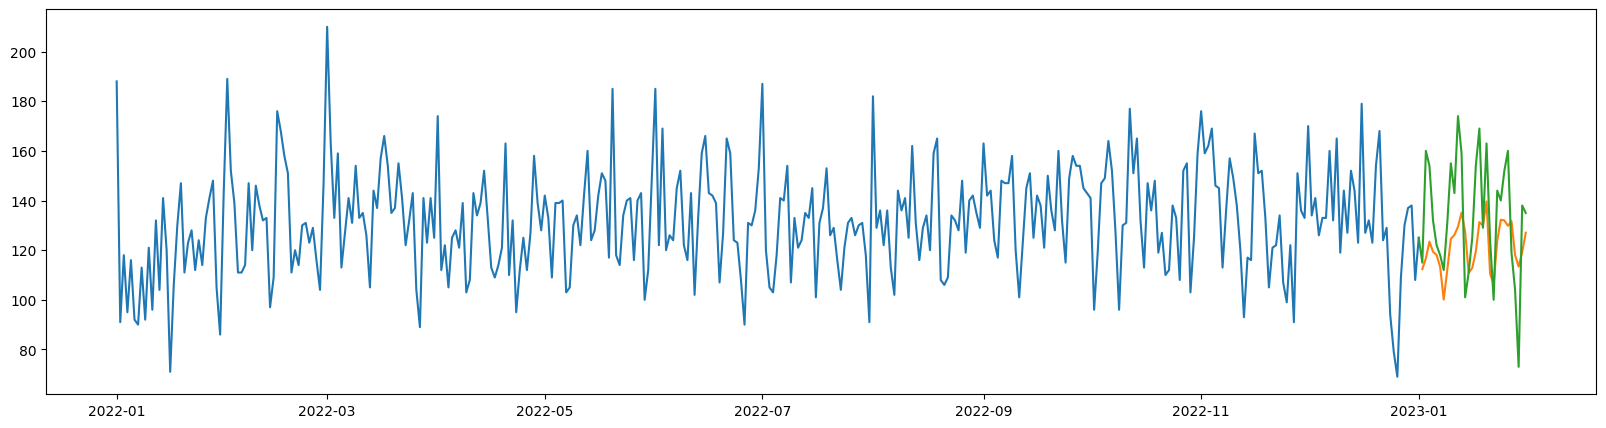

In [94]:
item_id = 'Crimes'
y_past = train_data.loc[item_id]['target']
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]['target'][-31:]

plt.figure(figsize=(20, 5))

plt.plot(y_past, label='Past time series values')
plt.plot(y_pred['mean'], label='Mean forecast')
plt.plot(y_test, label='Future time series values')